In [2]:
!pip install jieba
import os
import re
import sys
import math
import json
import jieba
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from tqdm import tqdm
import pandas as pd
#Data preprocessing: remove invalid characters
def dataPrepossing(one_line):
    sigmod_list = ['，', '。', '（', '）', '-', '——', '\n', '“', '”', '*', '#', '《', '》', '、', '[', ']', '(', ')', '-', '.',
                   '/', '】', '【']
    for one_sigmod in sigmod_list:
        one_line = one_line.replace(one_sigmod, '')
    return one_line


# Tokenize and remove stop words
def seg(one_content, stopwords=[]):

    #
    # l = []
    # pos = ['n', 'nz', 'v', 'vd', 'vn', 'l', 'a']  
    # seg = jieba.posseg.cut(one_content)  
    # for i in seg:
    #     if i.word not in stopwords and i.flag in pos:  
    #         l.append(i.word)
    # return l
    segs = jieba.cut(one_content, cut_all=False)
    segs = [w for w in segs if w not in stopwords and len(w)>2]
    return list(segs)

    # Read and tokenize text data
def cutData2Words(dataFile='email.csv', text_column='text', stopwords_file='stopwords.txt', save_path='cut_words.json'):
    result = {}
    data = pd.read_csv(dataFile)
    # data = data.head(1000)
    stopkey = [w.strip() for w in open(stopwords_file, 'r', encoding='utf-8').readlines()]
    # Add meaningless words to the stop word list
    stopkey.extend(['this', 'we', 'the', 'and', 'of', 'to', 'in', 'is', 'it', 'you', 'that', 'he', 'was', 'for', 'on', 'are', 'with', 'as', 'I','To','We','This','Please'])
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing Texts"):
        one_name = f'doc_{index}'
        one_data = dataPrepossing(row[text_column])
        one_words_list = seg(one_data, stopkey)
        result[one_name] = one_words_list
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(result, f, ensure_ascii=False)
    # print(result)

print('Loading.............................................')
cut_file ='./output/cut_words.json'
word_idf_file = './output/word_idf.json'

cutData2Words(dataFile='emails.csv', text_column='body', stopwords_file='stopwords-en.txt', save_path=cut_file)


     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
     ------ --------------------------------- 3.1/19.2 MB 18.4 MB/s eta 0:00:01
     ------ --------------------------------- 3.1/19.2 MB 18.4 MB/s eta 0:00:01
     -------- ------------------------------- 4.2/19.2 MB 6.6 MB/s eta 0:00:03
     --------- ------------------------------ 4.7/19.2 MB 5.7 MB/s eta 0:00:03
     ---------- ----------------------------- 5.2/19.2 MB 5.1 MB/s eta 0:00:03
     ------------ --------------------------- 5.8/19.2 MB 4.6 MB/s eta 0:00:03
     ------------- -------------------------- 6.3/19.2 MB 4.3 MB/s eta 0:00:04
     ------------- -------------------------- 6.3/19.2 MB 4.3 MB/s eta 0:00:04
     --------------- ------------------------ 7.3/19.2 MB 3.9 MB/s eta 0:00:04
     ---------------- ----------------------- 7.9/19.2 MB 3.8 MB/s eta 0:00:04
     ----------------- ---------------------- 8.4/19.2 MB 3.6 MB/s eta 0:00:03
     ------------------ --------------------- 8.9/19.2 MB

Processing Texts:   0%|          | 0/490845 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\26856\AppData\Local\Temp\jieba.cache
Loading model cost 1.185 seconds.
Prefix dict has been built successfully.
Processing Texts: 100%|██████████| 490845/490845 [1:44:35<00:00, 78.22it/s]    


In [3]:
import random

# Calculate the inverse document frequency of a word
def calWordsIdf(data='cut_words.json', save_path='word_idf.json', sample_size=10):
    with open(data, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    
    word_doc_list = []
    for one_key in data_dict:
        word_doc_list.append(data_dict[one_key])
    
    word_dict = {}
    for one_list in word_doc_list:
        for one in one_list:
            if one in word_dict:
                word_dict[one] += 1
            else:
                word_dict[one] = 1
    
    idf_dict = {}
    n = len(word_doc_list)
    for one_word in word_dict:
        idf_dict[one_word] = math.log(n * 1.0 / word_dict[one_word])
    
    # Randomly select some IDF values ​​to print
    sample_keys = random.sample(list(idf_dict.keys()), min(sample_size, len(idf_dict)))
    sample_idf = {key: idf_dict[key] for key in sample_keys}
    
    print(sample_idf)
    
    # Save the complete IDF dictionary
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(idf_dict, f, ensure_ascii=False)

print("Calculate the inverse document frequency of a word")
calWordsIdf(data=cut_file, save_path=word_idf_file)

Calculate the inverse document frequency of a word
{'8Mbps': 12.00527138598935, 'T44iE2FAFmSyI9b': 11.494445762223357, 'HicksCash': 10.801298581663414, 'Jocular': 13.103883674657459, '961154': 13.103883674657459, '24305': 13.103883674657459, 'Morges': 13.103883674657459, 'juleped': 12.410736494097513, 'SimmsApplewhite': 13.103883674657459, 'Eversheds': 13.103883674657459}


In [4]:
# Calculate the keywords of a single file data [filtered in descending order based on TF-IDF value]
def calTxtKeyWords(data='cut_words.json',word_idf_file='word_idf.json',topK=30):
    with open(word_idf_file, 'r', encoding='utf-8') as f:
        idf_dict = json.load(f)
    with open(data, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)

    tf_dict = {}
    for doc, words_list in data_dict.items():
        for one_word in words_list:
            if one_word in tf_dict:
                tf_dict[one_word] += 1
            else:
                tf_dict[one_word] = 1

    tfidf_dict = {}
    for one_word, tf in tf_dict.items():
        idf = idf_dict.get(one_word, 0)
        tfidf_dict[one_word] = tf * idf

    sorted_tfidf = sorted(tfidf_dict.items(), key=lambda e: e[1], reverse=True)

    # Save results
    excel_data = []
    for keyword, tfidf in sorted_tfidf[:topK]:
        word_count = tf_dict.get(keyword, 0)
        excel_data.append([keyword, word_count, tfidf])

    df = pd.DataFrame(excel_data, columns=['Keyword', 'Word Count', 'TF-IDF'])
    df.to_csv('keywords_tfidf.csv', index=False)

    return sorted_tfidf[:topK]
# Count the keywords of the email.csv file
result = calTxtKeyWords(data=cut_file, word_idf_file=word_idf_file,topK=60)
print(json.dumps(result, ensure_ascii=False, indent=2))

[
  [
    "company",
    180567.1382549373
  ],
  [
    "power",
    180536.78055695846
  ],
  [
    "email",
    180450.72896304188
  ],
  [
    "time",
    180135.94619571886
  ],
  [
    "Thanks",
    180055.01758696692
  ],
  [
    "Sent",
    178204.01362147921
  ],
  [
    "Message",
    176679.568372583
  ],
  [
    "market",
    176402.8483221488
  ],
  [
    "California",
    176033.6389567963
  ],
  [
    "Original",
    176014.18409367156
  ],
  [
    "price",
    175914.99948609568
  ],
  [
    "From",
    175556.99344385945
  ],
  [
    "Energy",
    173475.43871411058
  ],
  [
    "week",
    172917.5218537362
  ],
  [
    "Forwarded",
    172840.8723678844
  ],
  [
    "2001",
    168496.50128758937
  ],
  [
    "deal",
    167773.53981450296
  ],
  [
    "energy",
    167735.75490995232
  ],
  [
    "day",
    167030.1634498275
  ],
  [
    "2000",
    166977.63618203872
  ],
  [
    "enroncom",
    166010.62210287302
  ],
  [
    "John",
    163939.68734071273
  ],
  [

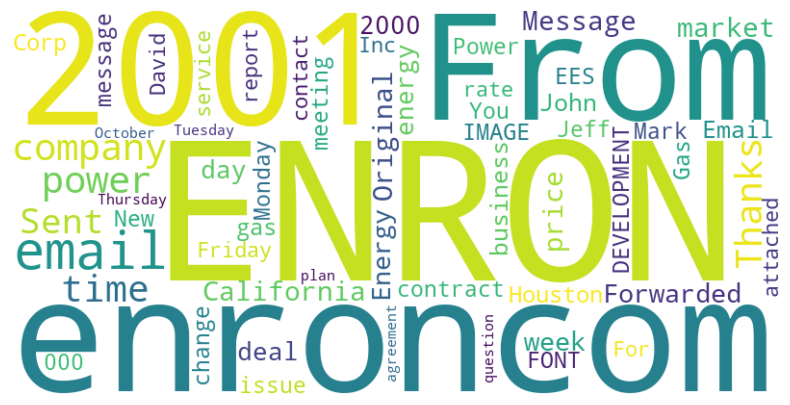

In [5]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Reading CSV Files
df = pd.read_csv('keywords_tfidf.csv')

# Create a dictionary containing words and word frequencies
word_freq = dict(zip(df['Keyword'], df['Word Count']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

#plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()